# 09 - Clasificación de textos con Scikit-Learn

* En este notebook vamos a ver como clasificar una serie de Tweets en Ingles sobre críticas a los productos de Apple.


* Estos tweets estan clasificados como: *positivos*, *neutros* o *negativos*


* El este notebook realizaremos los siguientes pasos:
    
    1. Carga de los datos (tweets)
    2. Normalización (en ingles) de los tweets
    3. Creacción de la Bolsa de Palabras
    4. Particionado de Datos
    5. Creacción de modelos
        - Multinomial Naive Bayes
        - Bernoulli Naive Bayes
        - Regresion Logistica
        - Support Vector Machine
        - Random Forest
    6. Evaluación de los modelos

<hr>


## Carga de Datos


* El primer paso que vamos a realizar es el de cargar los datos. Para ello ***leeremos el csv con pandas*** (pasandolo a un dataframe) y posteriormente lo transformaremos en una lista de tuplas (*tweets*) donde cada tupla esta formada por:
    - **Posición 0**: Tweet
    - **Posición 1**: Polaridad (Positivo | Neutro | Negativo)

In [1]:
import pandas as pd
tweets_file = './data/Apple_Tweets.csv'
df = pd.read_csv(tweets_file, header=None)
tweets = [tuple(x) for x in df.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 3804


<hr>


## Normalización

* Para este ejemplo haremos uso de ***spaCy***, pero en este caso tenemos que utilizar (e importar) el modelo para Inglés. Para ello: debemos de abrir un terminal en python y ejecutar lo siguiente para descargar el modelo en Ingles (*NOTA: los que uséis conda, tener activado el entorno*).


```
>> python3 -m spacy download en_core_web_sm
```


<img src="./imgs/010_spacy_en_download.png" style="width: 600px;"/>


* Para ***normalizar*** los tweets realizaremos las siguientes acciones:
    1. Pasamos las frases a minúsculas.
    2. Eliminamos los signos de puntuación.
    3. Eliminamos las palabras con menos de 3 caracteres.
    4. Eliminamos las Stop-Words.
    5. Eliminamos las palabras que empiecen por '@' o 'http'.
    6. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: *De cara a la normalización de textos se pueden realizar más acciones que las que vamos a realizar, pero con estas serán más que suficientes para realizar un ejercicio con fines didácticos*
    

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = [doc[1] for doc in tweets]

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop) 
                                     and (not word.text.startswith('@')) and (not word.text.startswith('http'))])
    return sentenses

# Normalizamos las frases
X = normalize(X)

<hr>


## Bolsa de Palabras


* El siguiente paso es transformar los tweets a una bolsa de palabras de frecuencias para que sirva de entrada al modelo.


* Dado que ya estamos trabajando con un corpus relativamente grande, es necesario reducir el diccionario de palabras (no confundir con un diccionario Python) para trabajar solo con las palabras más relevantes.


* La implementación de la clase "*CountVectorizer*" de scikit, permite quedarnos con las palabras más relevante. Para ello podemos utilizar dos parámetros que son:
    - **max_features**: Con este parámetro le indicamos que nos seleccione la '*X*' palabras más frecuentes del corpus. En este ejemplo **seleccionaremos las 1000 más frecuentes**.
    - **min_df**: Con este parámetro le indicamos el número mínimo de documentos en la que tiene que aparecer la palabra para que se incluya en la bolsa de palabras. En este ejemplo **seleccionaremos 3 documentos** (tweets).
    

* ***NOTA***: para más información podéis mirar la documentación de la clase "*CountVectorizer*" en: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, min_df=3)

# Pasamos los tweets normalizados a Bolsa de palabras
X = vectorizer.fit_transform(X)

<hr>


## Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 80% de datos de entrenamiento
    - 20% de datos de test

In [4]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 3043
Número de Tweets para el test: 761


<hr>


## Creacción del Modelo


* Una vez tenemos creada la bolsa de palabras, podemos usar cualquier algoritmo de aprendizaje para la clasificación.


* Para este ejemplo vamos a usar los siguientes algoritmos:

    - Multinomial Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    - Bernoulli Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
    - Regresion Logistica: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    - Support Vector Machine: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
    - Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    

* Para esta caso vamos a crear el modelo y calcular el accuracy para los datos de entrenamiento y tener una idea de que modelo puede funciona mejor:

In [5]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm = LinearSVC()
rf = RandomForestClassifier(max_depth=50, n_estimators=20, max_features=5)

clasificadores = {'Multinomial Naive Bayes': mnb,
                  'Bernoulli Naive Bayes': bnb,
                  'Regresion Logistica': lr,
                  'Support Vector Machine': svm,
                  'Random Forest': rf}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)
    accuracy_train = v.score(X_train, y_train)
    print ('\tAccuracy Train: {acc_train}'.format(acc_train=accuracy_train)) 

CREANDO MODELO: Multinomial Naive Bayes
	Accuracy Train: 0.7722642129477489
CREANDO MODELO: Bernoulli Naive Bayes
	Accuracy Train: 0.7653631284916201
CREANDO MODELO: Regresion Logistica
	Accuracy Train: 0.8613210647387447
CREANDO MODELO: Support Vector Machine
	Accuracy Train: 0.9017417022674992
CREANDO MODELO: Random Forest
	Accuracy Train: 0.8038120276043378


<hr>


## Evaluación del Modelo


* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **F1**
    3. **Precision**
    4. **Recall**

In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

evaluacion = list()
for k, v in clasificadores.items():
    print ('EVALUANDO MODELO: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred = v.predict(X_test)
    model['accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    model['f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    model['precision'] = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
    model['recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    evaluacion.append(model)

# Pasamos los resultados a un DataFrame para visualizarlos mejor
df = pd.DataFrame.from_dict(evaluacion)
df.set_index("name", inplace=True)
df.head()

EVALUANDO MODELO: Multinomial Naive Bayes
EVALUANDO MODELO: Bernoulli Naive Bayes
EVALUANDO MODELO: Regresion Logistica
EVALUANDO MODELO: Support Vector Machine
EVALUANDO MODELO: Random Forest


,accuracy,f1,precision,recall
name,,,,
Multinomial Naive Bayes,0.712221,0.715002,0.718937,0.712221
Bernoulli Naive Bayes,0.708279,0.709951,0.716078,0.708279
Regresion Logistica,0.752957,0.743281,0.748246,0.752957
Support Vector Machine,0.742444,0.738825,0.740317,0.742444
Random Forest,0.730618,0.695621,0.766853,0.730618


* Veamos la matriz de confusión para el modelo que mejores resultado obtiene que es la "***Regresión Logística***"

In [7]:
from sklearn.metrics import confusion_matrix

# Matriz de confusión para el modelo de Regresión Logística
confusion = confusion_matrix(y_true=y_test, 
                             y_pred=clasificadores['Regresion Logistica'].predict(X_test),
                             labels=['positive', 'neutral', 'negative'])

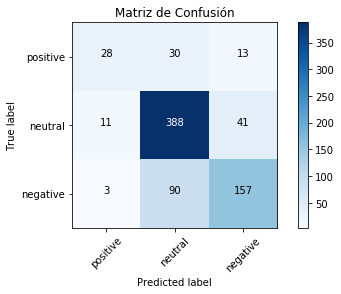

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure()
plot_confusion_matrix(confusion, classes=['positive', 'neutral', 'negative'], title='Matriz de Confusión')
plt.show()

<hr>


# Bonus Track


* Veamos a continuación un resumen de las métricas de evaluación para evaluar lo modelos generados por algoritmo de aprendizaje para la clasificación:


## - Matriz de confusión

* Cuando hablamos de clasificación tenemos que medir cuanto hemos acertado y como lo hemos acertado, por ello las ***matrices de confusión nos ayudan a ver el acierto o fallo que tiene nuestro modelo a la hora de clasificar***. La matriz de confusión tiene la siguiente forma:

    - **True Positive (TP)**: Valores positivos clasificados como positivos
    - **True Negative (TN)**: Valores negativos clasificados como negativos
    - **False Positive (FP)**: Valores negativos clasificados como positivos
    - **False Negative (FN)**: Valore positivos clasificados como negativos
    
<img src="./imgs/011_Matriz_Confusion.png" style="width: 400px;"/>


## - Accuracy

* Indica el porcentaje de acierto:

$$Acuracy = \frac{TP + TN}{TP + FN + FP + TN}$$

## - Precision

* Los positivos correctamente pronosticados entre todos los ejemplos pronosticados como positivos. 


* "***De lo que hemos pronosticado, cuanto hemos acertado***"


$$Precision = \frac{TP}{TP + FP}$$


<img src="./imgs/012_Matriz_Confusion_precision.png" style="width: 400px;"/>
                                                               
                                                               

## - Recall


* Los positivos correctamente pronosticados, entre todos los ejemplos que son positivos. 


* "***De lo que hay en realidad, cuanto hemos acertado***"


$$Recall = \frac{TP}{TP + FN}$$


<img src="./imgs/013_Matriz_Confusion_recall.png" style="width: 400px;"/>


## - F1 (Precision-Recall)


* Es una media que combina la precisión y el recall. 


* Si es cercano a ***1*** significa que la clasificación realizada es buena. 


* Si es cercano a ***0*** la clasificación realizada es mala.


$$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$


<img src="./imgs/014_Matriz_Confusion_f1.png" style="width: 400px;"/>


## - Métricas en Sckit-Learn:

* Scikit-Learn dispone del módulo “metrics” donde tiene implementados todos estos métodos de evaluación


* Como norma general se le pasa como parámetros un array con la clasificación verdadera y otro array con la predicción:

    - **metrics.confusion_matrix(y_true, y_pred[, …])**: Compute confusion matrix to evaluate the accuracy of a classification
    - **metrics.accuracy_score(y_true, y_pred[, …])**: Accuracy classification score
    - **metrics.precision_score(y_true, y_pred[, …])**: Compute the precision
    - **metrics.recall_score(y_true, y_pred[, …])**: Compute the recall
    - **metrics.f1_score(y_true, y_pred[, labels, …])**: Compute the F1 score, also known as balanced F-score or F-measure
    - **metrics.classification_report(y_true, y_pred)**: Build a text report showing the main classification metrics
